In [1]:
import matplotlib
# matplotlib.use('nbagg')
# from matplotlib import style
# style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc, extract
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from datetime import date, timedelta

In [2]:
engine = create_engine("sqlite:///hawaii2.sqlite", echo=False)

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
session = Session(engine)

In [6]:
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>='2016-08-23').order_by(Measurement.date)

In [7]:
precipdf = pd.read_sql(precip.statement, precip.session.bind)

In [8]:
precipdf.dropna(inplace=True)
precipdf.set_index('date', inplace=True)
precipdf.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


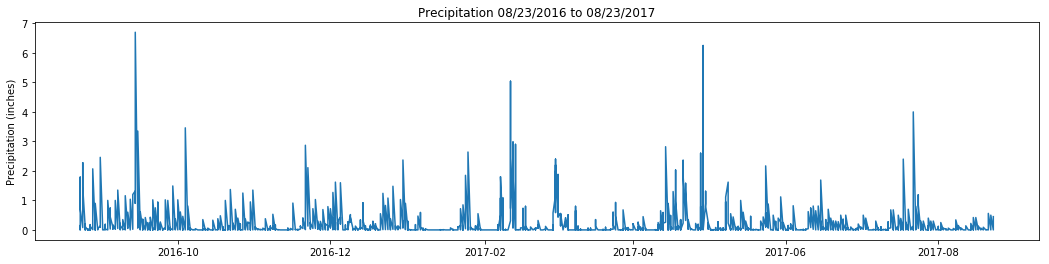

In [9]:
plt.figure(figsize=(18,4))
plt.plot(precipdf.index, precipdf["prcp"])
plt.ylabel("Precipitation (inches)")
plt.xlabel("")
x_pos = np.arange(len(precipdf.index))
xticks = [x for x in precipdf.index]
# plt.xticks(x_pos,xticks)
plt.title("Precipitation 08/23/2016 to 08/23/2017")
plt.show()

In [10]:
precipdf.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [11]:
stationCount = session.query(Station.id).count()
stationCount

9

In [12]:
stationCounts = session.query(Station.name,Measurement.station,func.count(Measurement.id).label('stationCounts')).filter(Station.station==Measurement.station).group_by(Station.id,Measurement.station).order_by(desc('stationCounts')).all()
stationCounts

[('WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('PEARL CITY, HI US', 'USC00517948', 1372),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [13]:
stationCountsSubquery = session.query(Measurement.station.label('station'),func.count(Measurement.id).label('stationCounts')).group_by(Measurement.station).order_by(desc('stationCounts')).subquery()
stationCountsSubquery
maxObs = session.query(stationCountsSubquery.c.station,func.max(stationCountsSubquery.c.stationCounts)).scalar()
maxObs

'USC00519281'

In [14]:
lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
yearAgo = lastDate[0]- relativedelta(years=1)
yearAgo

datetime.date(2016, 8, 23)

In [15]:
tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>=yearAgo).filter(Measurement.station==maxObs).order_by(Measurement.date).all()

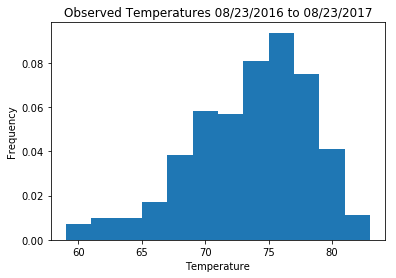

In [16]:
temps = [x[1] for x in tobs]
plt.hist(temps, normed=True, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Observed Temperatures 08/23/2016 to 08/23/2017")
plt.show()

### Temperature Analysis

In [17]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
class Temp():
    def __init__(self, minimum, average, maximum):
        self.minimum = minimum
        self.average = average
        self.maximum = maximum
        

def calc_temps(sd, ed):
    minimum = session.query(func.min(Measurement.tobs)).filter(Measurement.date.between(sd,ed)).scalar()
#     print(f"Minimum temp: {minimum}")
    average = session.query(func.round(func.avg(Measurement.tobs))).filter(Measurement.date.between(sd,ed)).scalar()
#     print(f"Average temp: {average}")
    maximum = session.query(func.max(Measurement.tobs)).filter(Measurement.date.between(sd,ed)).scalar()
#     print(f"Maximum temp: {maximum}")
    
#     result = [{"Minimum":minimum},{"Maximum":maximum},{"Average":average}]
    result = Temp(minimum, average, maximum)
    return result
              
    
t = calc_temps('2016-10-01','2016-10-14')
t.minimum, t.average, t.maximum

(71.0, 78.0, 82.0)

In [18]:
previousYearTemps = calc_temps('2015-10-01','2015-10-14')
previousYearTemps.minimum, previousYearTemps.average, previousYearTemps.maximum

(66.0, 76.0, 84.0)

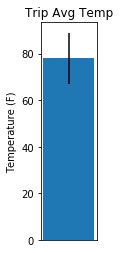

In [19]:
plt.figure(figsize=(1,4))
err=t.maximum-t.minimum
x_axis = 0
plt.bar(x_axis, t.average, yerr=err)
plt.xticks([0])
plt.ylabel("Temperature (F)")
plt.title("Trip Avg Temp")
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
plt.show()

In [20]:
# rainfall per weather station
stationRainfall = session.query(Measurement.station,func.sum(Measurement.prcp)).filter(Measurement.date.between('2015-10-01','2015-10-14')).group_by(Measurement.station).all()
stationRainfall

[('USC00511918', 0.4),
 ('USC00513117', 5.05),
 ('USC00514830', 8.76),
 ('USC00516128', 2.8299999999999996),
 ('USC00517948', None),
 ('USC00518838', 0.0),
 ('USC00519281', 5.07),
 ('USC00519397', 0.2),
 ('USC00519523', 5.550000000000001)]

In [21]:
def daily_normals(monthDay):
    dateMonth = parse(monthDay).month
    dateDay = parse(monthDay).day
    minimum = session.query(func.min(Measurement.tobs)).filter(extract('month', Measurement.date) == dateMonth).filter(extract('day', Measurement.date) == dateDay).scalar()
    average = session.query(func.round(func.avg(Measurement.tobs))).filter(extract('month', Measurement.date) == dateMonth).filter(extract('day', Measurement.date) == dateDay).scalar()
    maximum = session.query(func.max(Measurement.tobs)).filter(extract('month', Measurement.date) == dateMonth).filter(extract('day', Measurement.date) == dateDay).scalar()
    
    result = Temp(minimum, average, maximum)
    return result

t = daily_normals('10-06')
t.minimum, t.average, t.maximum

(70.0, 75.0, 81.0)

In [22]:
# Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
sd = parse('2016-10-01')  # start date
ed = parse('2016-10-14')  # end date

delta = ed - sd         # timedelta

vacationDates = []
dailyNorms = []
for i in range(delta.days + 1):
    vacationDates.append((sd + timedelta(days=i)).strftime("%m-%d"))
for md in vacationDates:
    dn = daily_normals(md)
    dailyNorms.append({"MonthDay":md,"DailyNormMinimum":dn.minimum,"DailyNormAverage":dn.average,"DailyNormMaximum":dn.maximum})
dailyNorms

[{'DailyNormAverage': 75.0,
  'DailyNormMaximum': 80.0,
  'DailyNormMinimum': 69.0,
  'MonthDay': '10-01'},
 {'DailyNormAverage': 76.0,
  'DailyNormMaximum': 83.0,
  'DailyNormMinimum': 70.0,
  'MonthDay': '10-02'},
 {'DailyNormAverage': 77.0,
  'DailyNormMaximum': 84.0,
  'DailyNormMinimum': 66.0,
  'MonthDay': '10-03'},
 {'DailyNormAverage': 76.0,
  'DailyNormMaximum': 82.0,
  'DailyNormMinimum': 67.0,
  'MonthDay': '10-04'},
 {'DailyNormAverage': 76.0,
  'DailyNormMaximum': 84.0,
  'DailyNormMinimum': 67.0,
  'MonthDay': '10-05'},
 {'DailyNormAverage': 75.0,
  'DailyNormMaximum': 81.0,
  'DailyNormMinimum': 70.0,
  'MonthDay': '10-06'},
 {'DailyNormAverage': 76.0,
  'DailyNormMaximum': 81.0,
  'DailyNormMinimum': 68.0,
  'MonthDay': '10-07'},
 {'DailyNormAverage': 76.0,
  'DailyNormMaximum': 86.0,
  'DailyNormMinimum': 66.0,
  'MonthDay': '10-08'},
 {'DailyNormAverage': 76.0,
  'DailyNormMaximum': 84.0,
  'DailyNormMinimum': 69.0,
  'MonthDay': '10-09'},
 {'DailyNormAverage': 76.0,


In [23]:
# Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
vacationNorms = pd.DataFrame.from_records(dailyNorms).set_index('MonthDay')
vacationNorms

,DailyNormAverage,DailyNormMaximum,DailyNormMinimum
MonthDay,,,
10-01,75.0,80.0,69.0
10-02,76.0,83.0,70.0
10-03,77.0,84.0,66.0
10-04,76.0,82.0,67.0
10-05,76.0,84.0,67.0
10-06,75.0,81.0,70.0
10-07,76.0,81.0,68.0
10-08,76.0,86.0,66.0
10-09,76.0,84.0,69.0


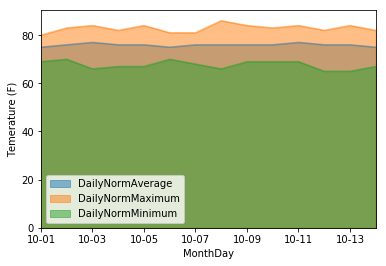

In [24]:
# Use Pandas to plot an area plot (stacked=False) for the daily normals.
vacationNorms.plot(kind='area', stacked=False)
plt.ylabel("Temerature (F)")
plt.show()